In [8]:
import os
import wandb
import itertools
import pandas as pd 
os.environ["HTTPS_PROXY"] = "http://10.21.0.15:7890"    
api = wandb.Api()

In [3]:
def get_single_method(method,dataset,hypers):
    algs = method if isinstance(method,list) else [method]
    datasets = dataset if isinstance(dataset,list) else [dataset]
    runs = api.runs("henrytujia/FedTH")
    res = pd.DataFrame()

    for alg,dataset in itertools.product(algs,datasets):
        hypers.update({"method":alg,"dataset":dataset})
        for run in runs:
            # if run.id == "1qomda2w":
            #     print("ok")
            if not(run.state == 'finished'):
                continue
            state_list = [key in run.config.keys() and hypers[key] == run.config[key] for key in hypers.keys()]
            if not all(state_list):
                continue
            history = run.history()
            temp_df = pd.DataFrame({**run.config,"id":run.id,'global_test_acc':history['global_test_acc'],"epochs":[x for x in range(hypers["comm_round"])]})
            res = pd.concat([res,temp_df])
                
    return res


In [4]:
alg = ["fedbalance"]
dataset = ["covid"]
hypers = {
    "comm_round":100,
    "client_number":20,
    "partition_method":"hetero",
    "epochs":10,
    # "partition_alpha":0.3
    "local_model":"lenet"
}

df = get_single_method(alg,dataset,hypers)
# print()

In [5]:
print(df["id"].unique())

['37kxo2kc' '3hi1qysn' 'tb66pwt4' 'ddy7y2zg' 'zp7rwu2c' '2w09te58'
 '293rjlpg' 'srbb26ac' '2684gg84']


In [7]:
for  item in itertools.product(alg,dataset,[0.5,0.3,0.1]):
    m,d,a = item
    temp_df = df[(df["method"]==m)&(df["dataset"]==d)&(df["partition_alpha"]==a)]
    # print(temp_df["global_test_acc"])
    mean_accs = temp_df.groupby("epochs").mean()["global_test_acc"]
    print(m,d,a,mean_accs.tail(10).mean(),mean_accs.tail(10).std())
    # break

fedbalance covid 0.5 74.28194867886178 3.3615068338755862
fedbalance covid 0.3 58.53118648373984 5.898620503915266
fedbalance covid 0.1 54.69925050813008 6.59817120328782


#### loss

fedict cifar10 0.5 77.95305822649571 0.6013533213365148
fedict cifar10 0.3 75.48344017094017 0.6996050865684369
fedict cifar10 0.1 67.67094017094017 0.8924363672573657
fedict cifar100 0.5 55.887419871794876 0.3177530074942643
fedict cifar100 0.3 51.85296 0.32
fedict cifar100 0.1 50.56390224358974 0.32767657226713587
fedict cinic10 0.5 57.33447590218423 0.7506156129806099
fedict cinic10 0.3 53.01404469373219 0.9471833577220373
fedict cinic10 0.1 42.87842028727446 2.1041818560622367

#### probs

fedict cifar10 0.5 76.93175747863249 1.0569725643418644
fedict cifar10 0.3 75.07244925213675 0.9149932701677147
fedict cifar10 0.1 61.886351495726494 1.8789464157524083
fedict cifar100 0.5 57.07365117521367 0.2481271588350607
fedict cifar100 0.3 56.470686431623925 0.3494735660751884
fedict cifar100 0.1 50.51749465811966 0.3335795803727152
fedict cinic10 0.5 56.9280107431149 1.3936003765791838
fedict cinic10 0.3 51.856266322412154 1.4134459471048346
fedict cinic10 0.1 38.37881350902184 1.9733524222861305
 
### logits
fedict cifar10 0.5 77.57244925213676 0.6433209183866295
fedict cifar10 0.3 76.01161858974359 0.5114433489269291
fedict cifar10 0.1 67.7240251068376 1.1191449063363648
fedict cifar100 0.5 55.40932158119657 0.3163185084587472
fedict cifar100 0.3 54.40137553418804 0.3118440116070171
fedict cifar100 0.1 50.84301549145299 0.4060961517910973
fedict cinic10 0.5 56.82822145061728 0.686960528000864
fedict cinic10 0.3 53.26118085232668 0.9043982782676703
fedict cinic10 0.1 43.39951329534664 1.9837480443486633

alexnet

fedbalance cifar10 0.5 77.2933360042735 0.9085120835305622
fedbalance cifar10 0.3 75.71380876068376 0.8028818670451615
fedbalance cifar10 0.1 67.90431356837607 1.6468110005385206
fedbalance cifar100 0.5 55.172943376068375 0.5130151120288345
fedbalance cifar100 0.3 53.60777243589743 0.443088088670183
fedbalance cifar100 0.1 49.461137820512825 0.5467647961673785
fedbalance cinic10 0.5 55.806549738841404 1.0056125763452393
fedbalance cinic10 0.3 51.04040538936372 1.6596397831413845
fedbalance cinic10 0.1 43.02279944207028 1.9683105642252068


lenet

fedbalance cifar10 0.5 77.77577457264957 1.1049881370369423
fedbalance cifar10 0.3 75.80194978632478 1.0957459860059047
fedbalance cifar10 0.1 66.70138888888889 1.7110211711351697
fedbalance cifar100 0.5 54.1109107905983 0.3442696754187944
fedbalance cifar100 0.3 54.4921875 0.49584298055446197
fedbalance cifar100 0.1 49.57365117521367 0.540415457030978
fedbalance cinic10 0.5 55.51100278964862 0.8877697483991835
fedbalance cinic10 0.3 50.76055021367521 1.5712401542679557
fedbalance cinic10 0.1 42.88346539648624 1.839297857352767

In [48]:
def get_single_method_local(method,dataset,hypers):
    import numpy
    algs = method if isinstance(method,list) else [method]
    datasets = dataset if isinstance(dataset,list) else [dataset]
    runs = api.runs("henrytujia/FedTH")
    res = pd.DataFrame()

    for alg,dataset in itertools.product(algs,datasets):
        hypers.update({"method":alg,"dataset":dataset})
        for run in runs:
            if not(run.state == 'finished'):
                continue
            state_list = [key in run.config.keys() and hypers[key] == run.config[key] for key in hypers.keys()]
            if not all(state_list):
                continue
            history = run.history()
            local_test_acc_temp = history['local_test_acc']
            local_test = [[] for x in range(4)]
            for item in local_test_acc_temp:
                for i in range(len(item)):
                    local_test[i].append(item[i])

            for i in range(4):
                temp_df = pd.DataFrame({**run.config,"id":run.id,'local_test_acc':local_test[i],"client":i,"epochs":[x for x in range(hypers["comm_round"])]})
                res = pd.concat([res,temp_df])
                
    return res


In [49]:
alg = ["fedbalance","fedavg","fedrs","fedrod","moon","fedprox"]
dataset = ["cifar10"]
hypers = {
    "comm_round":100,
    "client_number":20,
    "partition_method":"hetero",
    "epochs":10,
    "partition_alpha":0.1,
    "local_valid":True
}

df_local = get_single_method_local(alg,dataset,hypers)
# print()

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [52]:
newdf1 = df_local.groupby(['method', 'epochs',"client"]).first().reset_index ()

In [53]:
newdf1

,method,epochs,client,lr,mu,wd,experi,datadir,dataset,batch_size,...,pretrained,local_valid,save_client,client_number,client_sample,thread_number,partition_alpha,partition_method,id,local_test_acc
0,fedavg,0,0,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,3hatre45,0.177976
1,fedavg,0,1,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,3hatre45,0.158475
2,fedavg,0,2,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,3hatre45,0.260473
3,fedavg,0,3,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,3hatre45,0.187888
4,fedavg,1,0,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,3hatre45,0.100100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,moon,98,3,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,1ez5fc1e,0.251456
2396,moon,99,0,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,1ez5fc1e,0.251253
2397,moon,99,1,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,1ez5fc1e,0.243507
2398,moon,99,2,0.01,0.45,0.0001,0,/home/wuxingxing/dataset/cifar10,cifar10,64,...,False,True,False,20,0.2,4,0.1,hetero,1ez5fc1e,0.271142


KeyError: "['method', 'epochs'] not in index"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


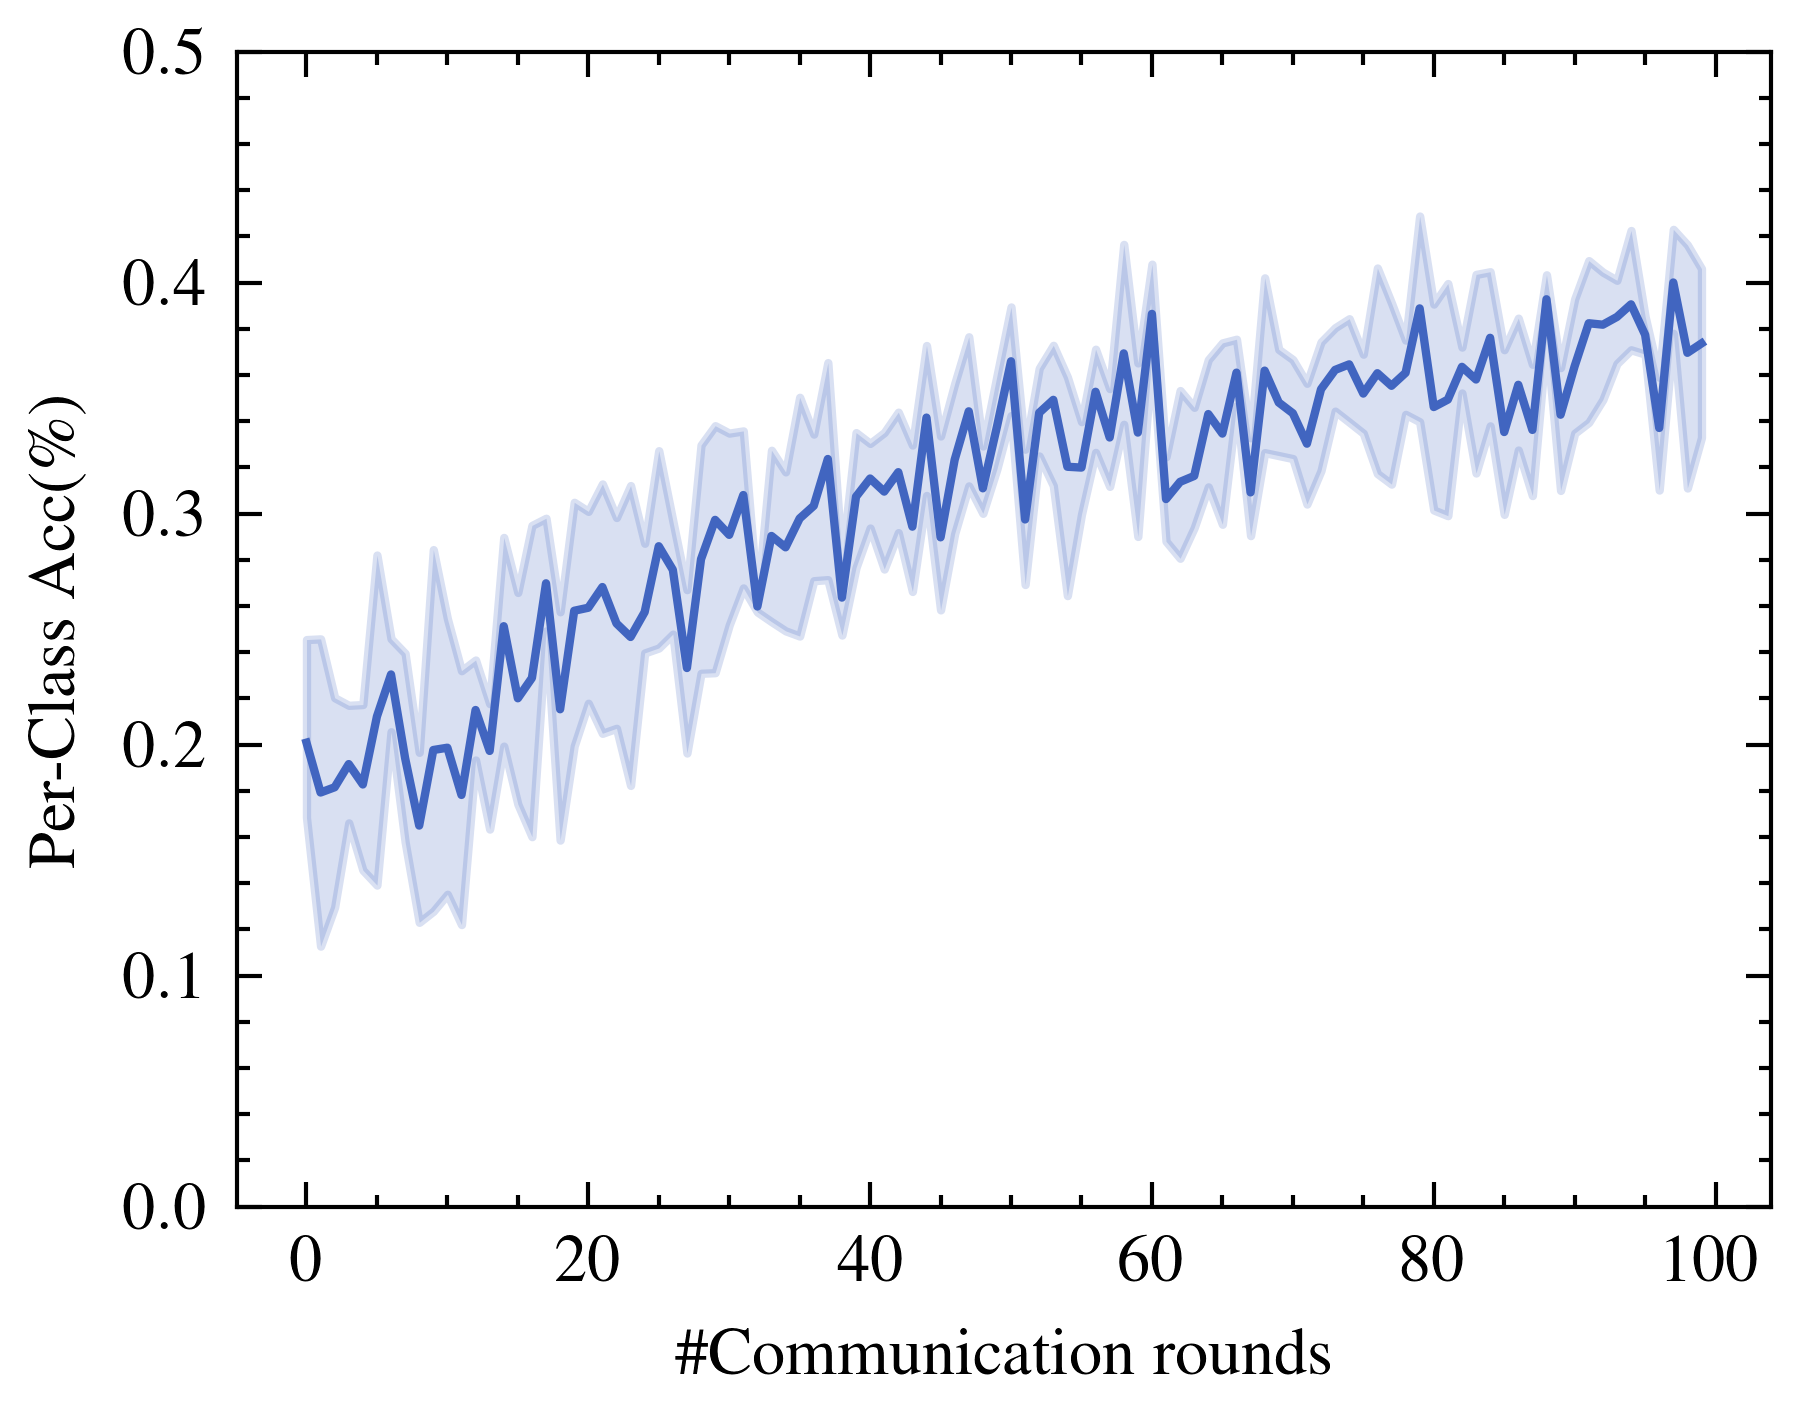

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


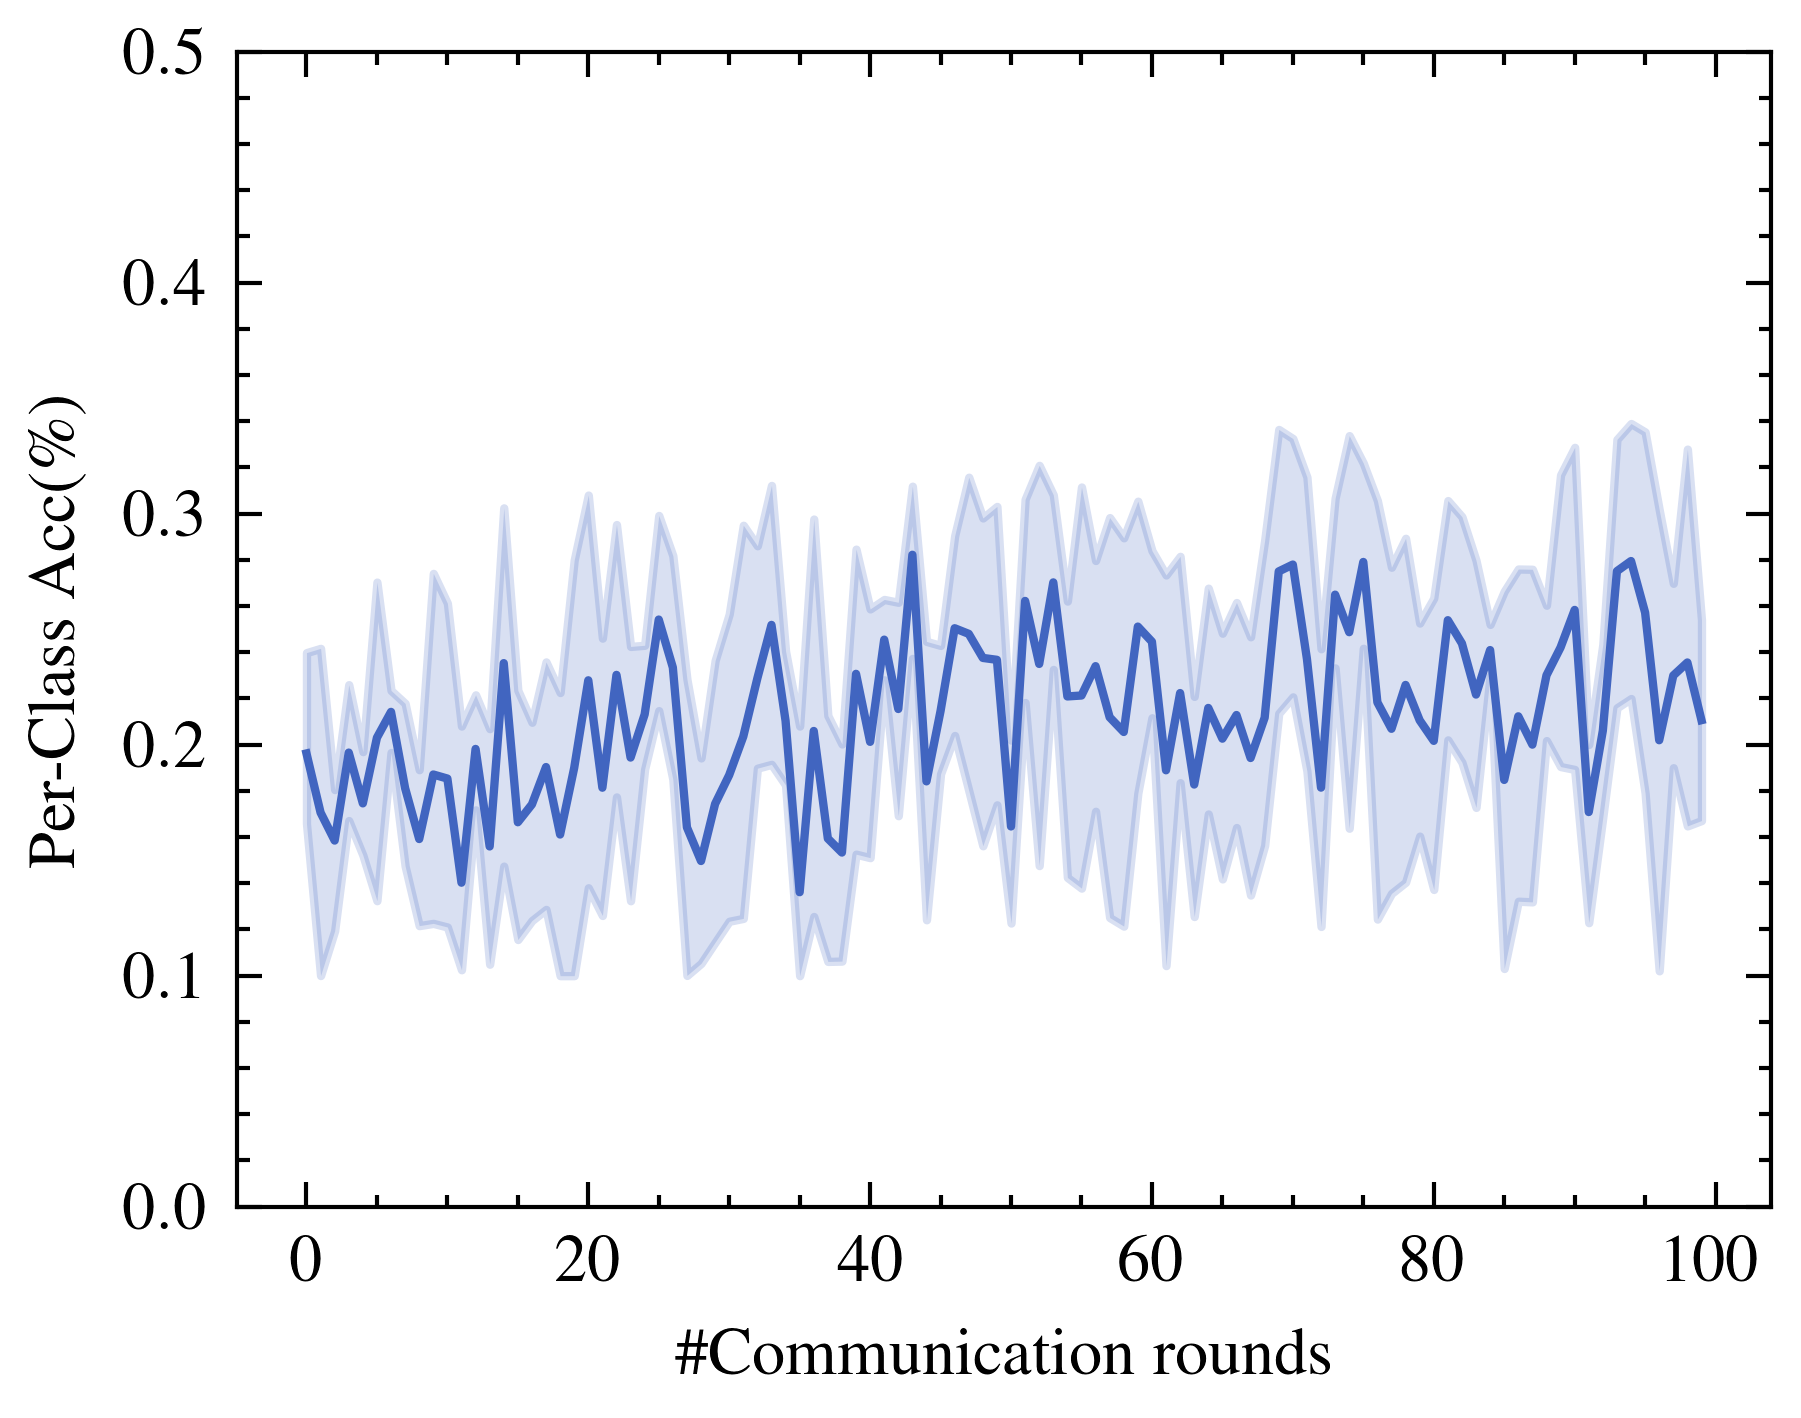

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


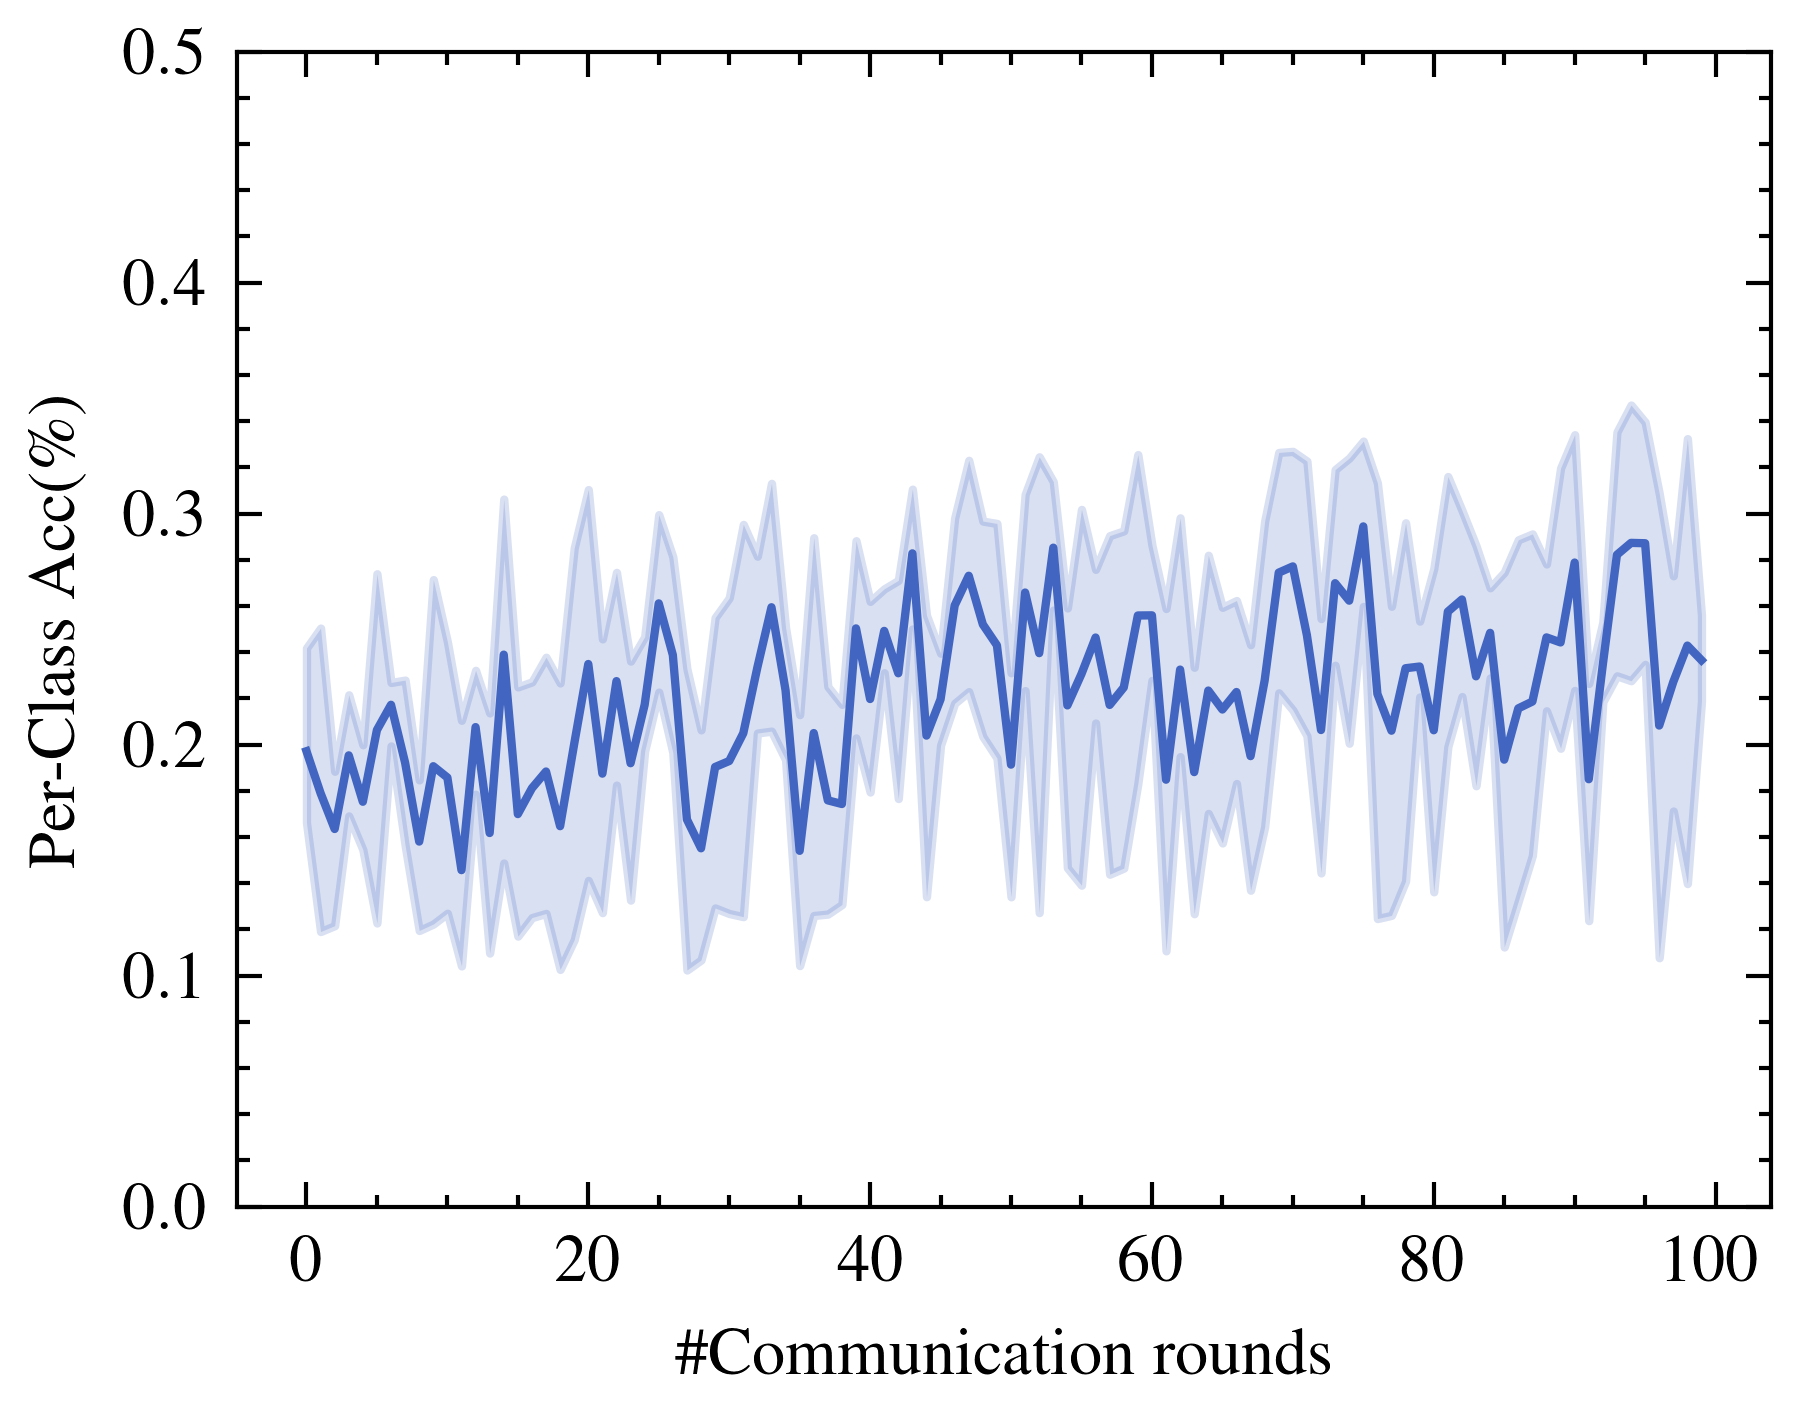

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


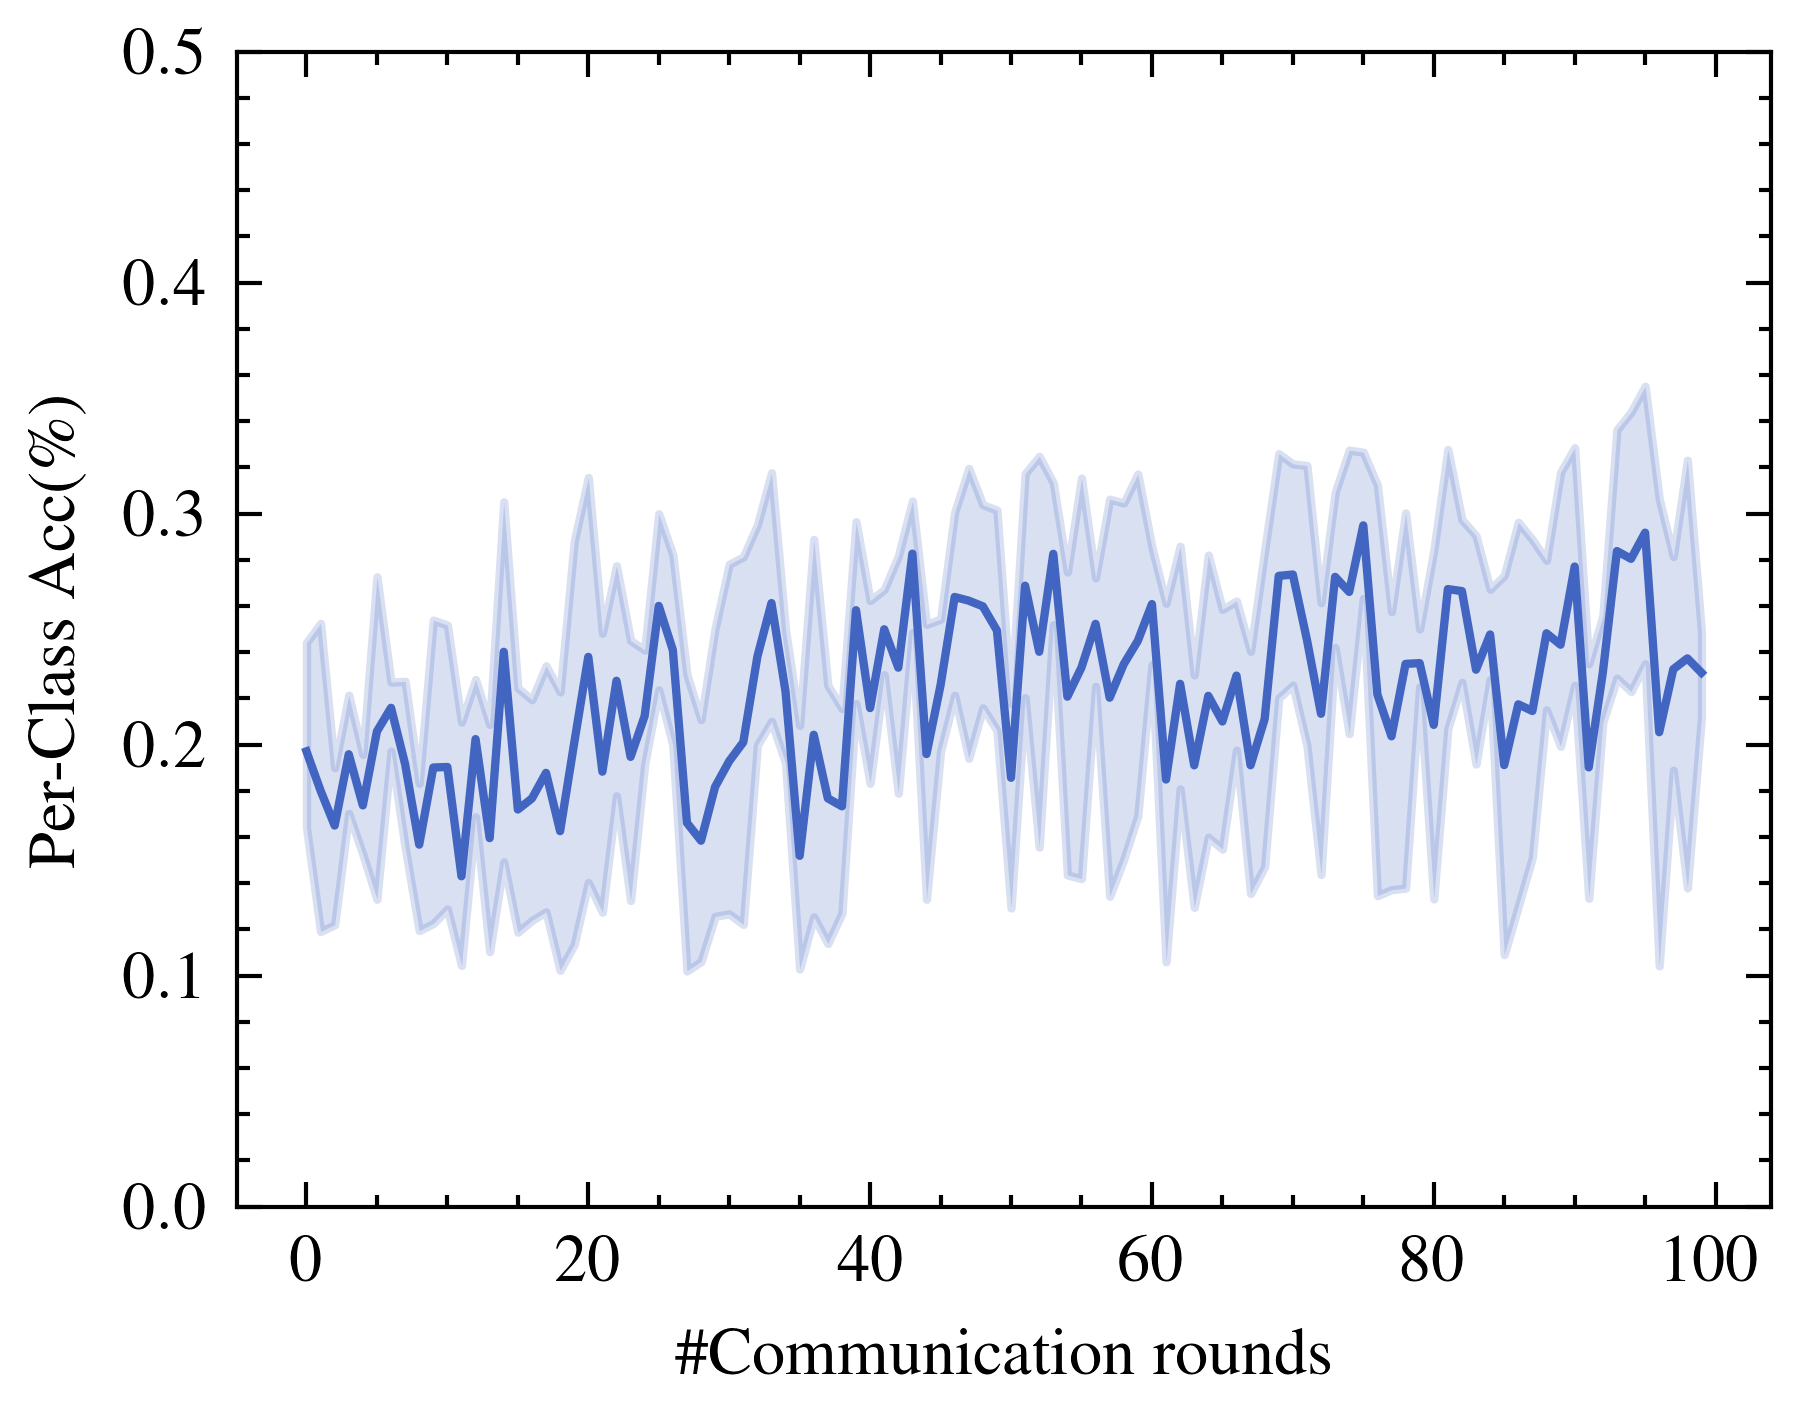

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


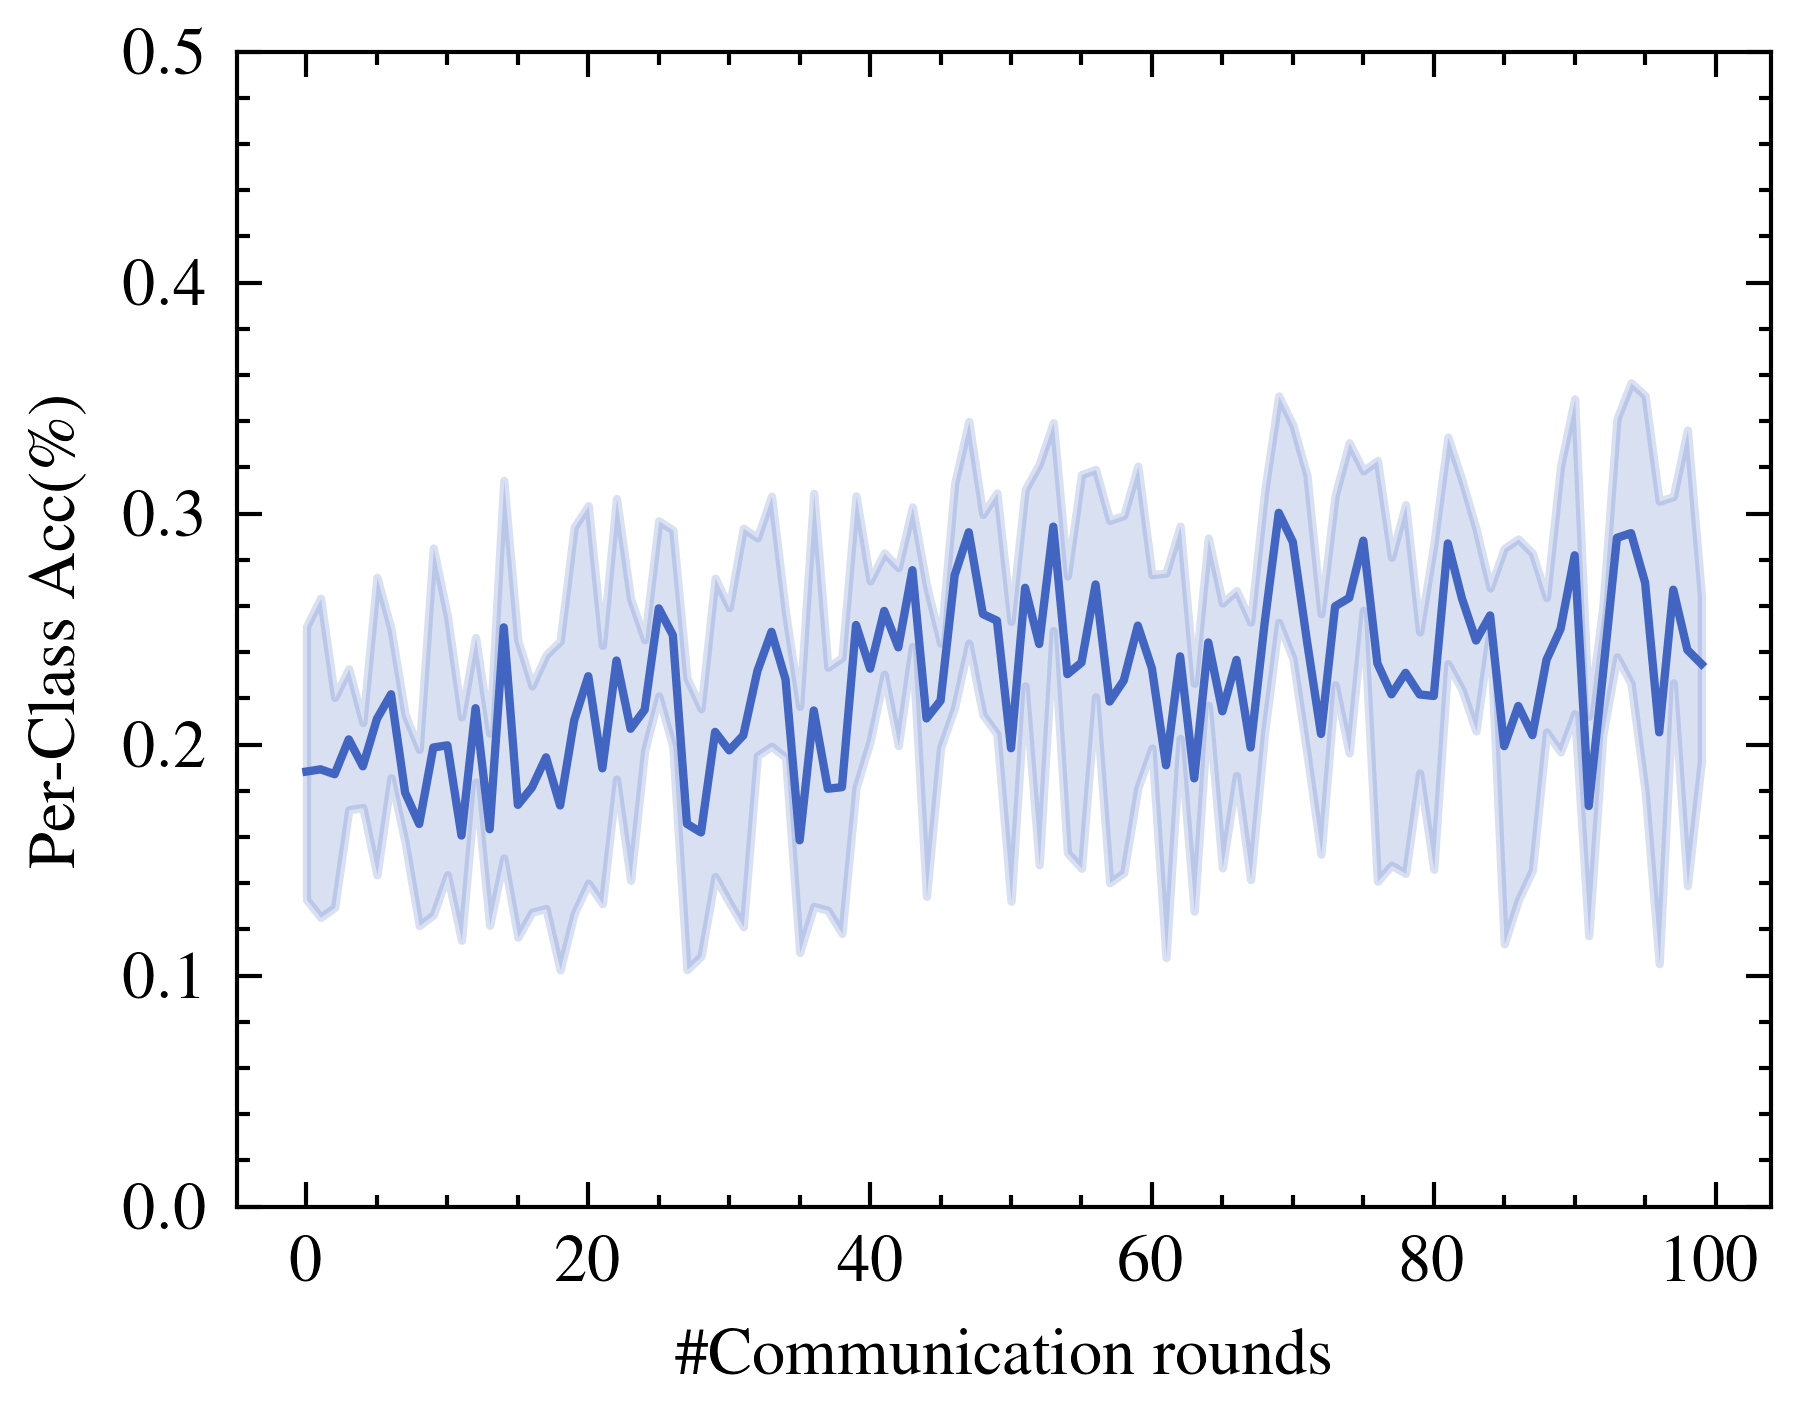

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


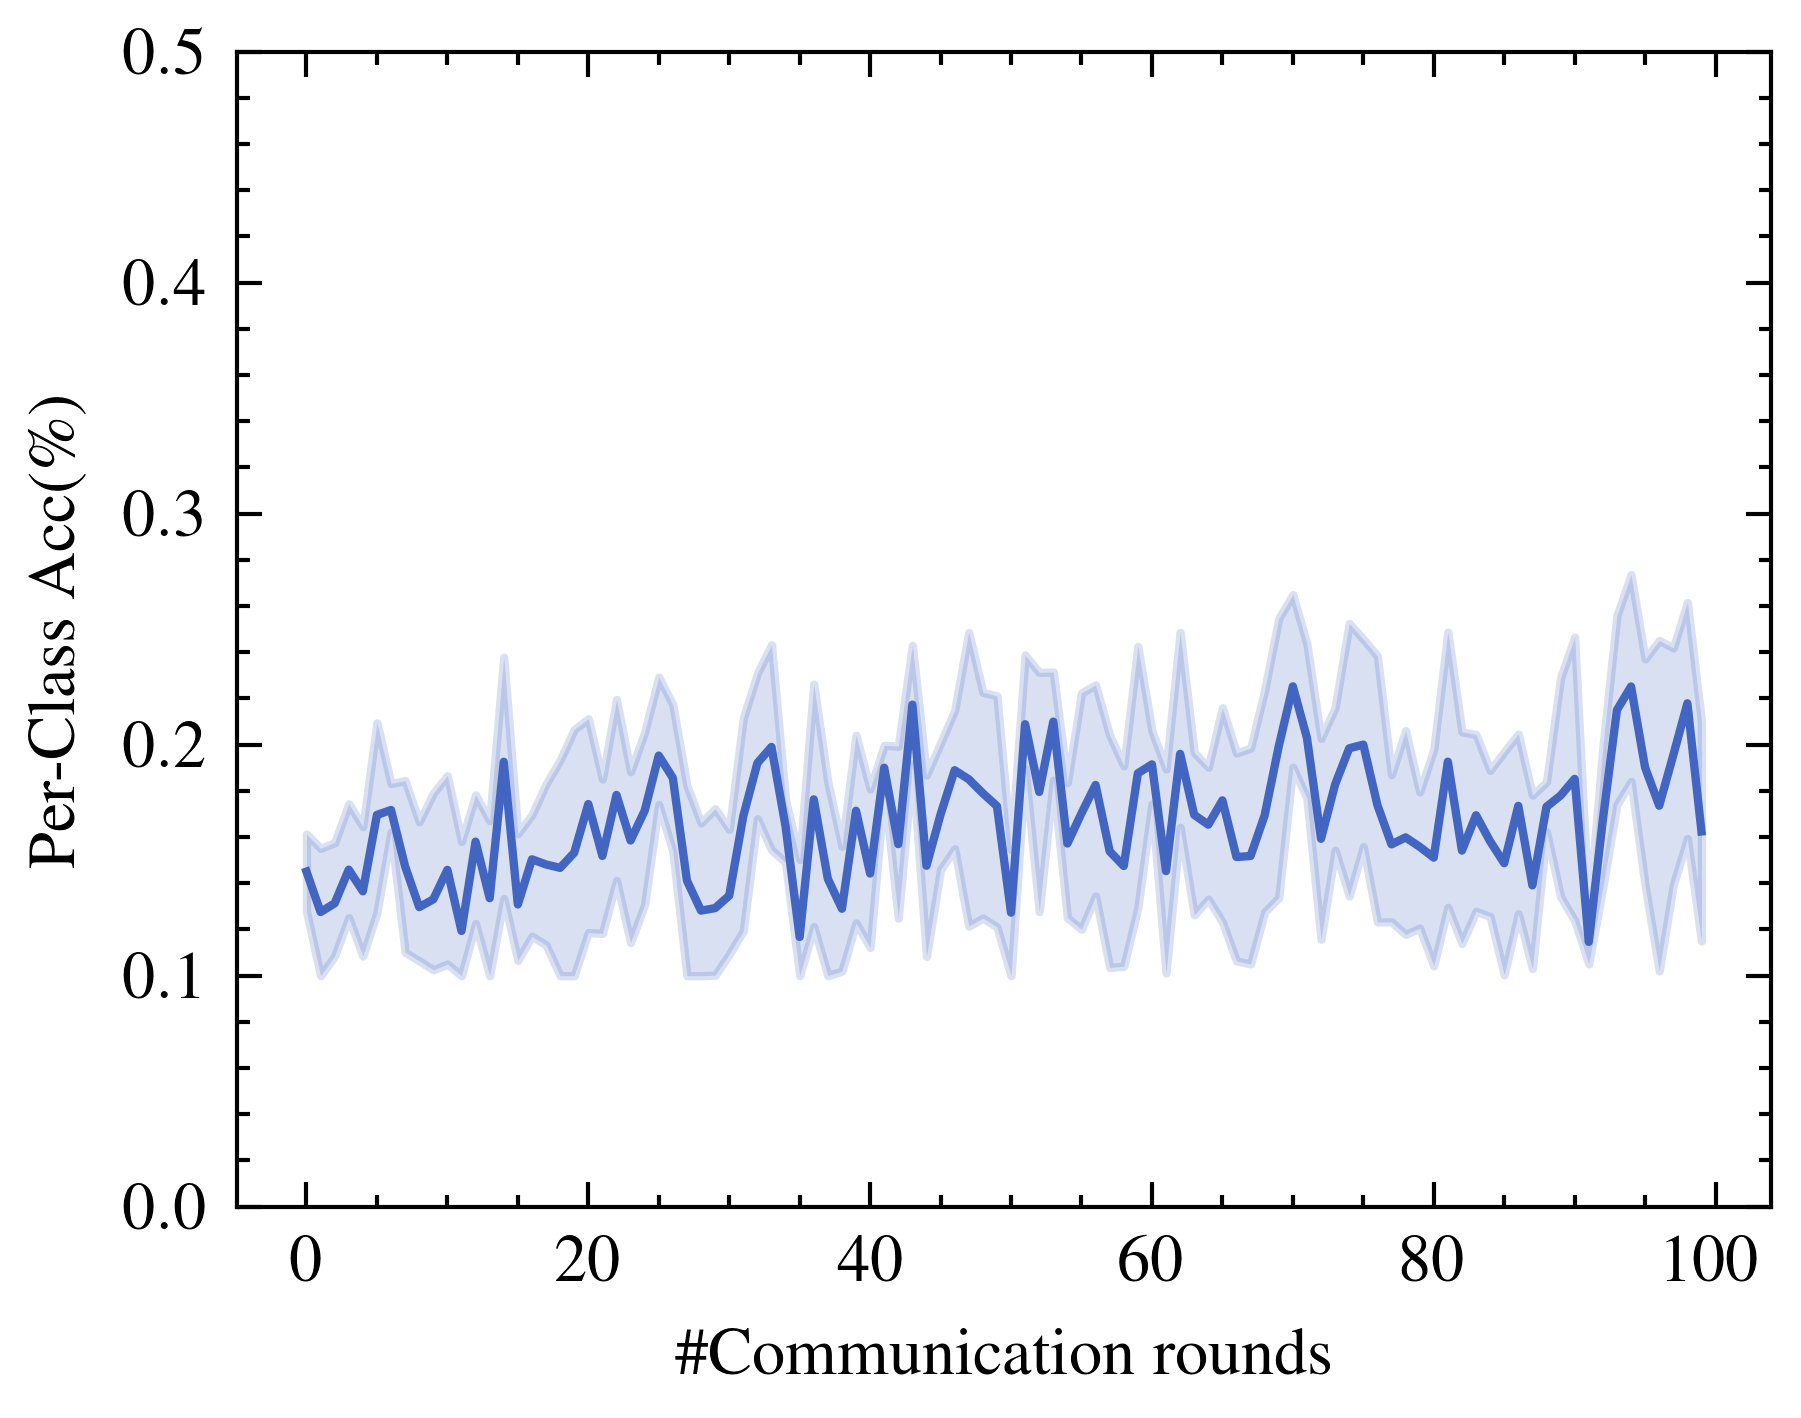

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','retro'])

# g =sns.relplot(
#     data=newdf1, x="epochs", y="local_test_acc",
#     col="method",     kind="line",
#     col_wrap=3
# )

# (g.map()
#   .set_axis_labels("\#Communication rounds", "Per-Class Acc(\%)")
#   .set_titles("Method: {col_name}")
#   .tight_layout(w_pad=0))

# plt.ylim(0,0.5)
# plt.legend()
# # plt.savefig(os.path.join(*[dataset[0]]).replace("/","_")+".pdf",dpi = 300)
# plt.show()

for alg in ["fedbalance","fedavg","fedrs","fedrod","moon","fedprox"]:
    

    df_plot = newdf1[newdf1["method"]==alg]

    fig, ax = plt.subplots()
    ax.set_xlabel('\#Communication rounds')
    ax.set_ylabel('Per-Class Acc(\%)')
    sns.lineplot(data=df_plot, x="epochs", y="local_test_acc")
    plt.ylim(0,0.5)
    plt.legend()
    plt.savefig(os.path.join("./saved/",alg)+"_clients.pdf",dpi = 300)
    plt.show()